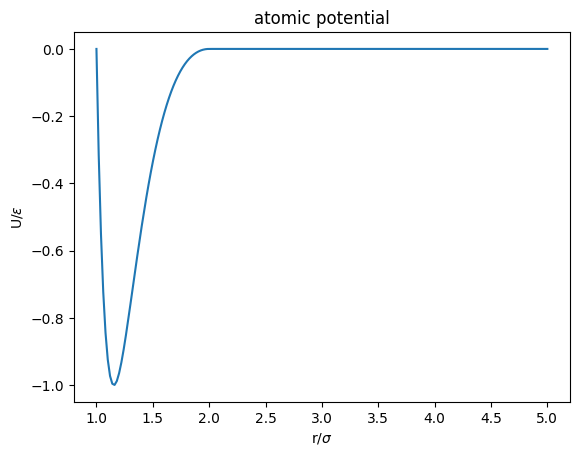

In [416]:
from itertools import combinations
from typing import Callable
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

def lj_potential(x: float) -> float:  # obfuscated, but fast implementation!
    r6 = 1 / x / x
    r6 *= r6 * r6
    return 4 * r6 * (r6 - 1)

def lj_potential_cut(x:float)->float:
    if x>=2.5:
        return 0
    else:
        return lj_potential(x)-lj_potential(2.5)


def pairwise_potential(potential: Callable[[float], float], xss: [[float]], box:float) -> float:
    """
    >>> lj13 = [
    ...     [  1.0132226417,  0.3329955686,  0.1812866397],
    ...     [   0.7255989775, -0.7660449415,  0.2388625373],
    ...     [   0.7293356067, -0.2309436666, -0.7649239428],
    ...     [   0.3513618941,  0.8291166557, -0.5995702064],
    ...     [   0.3453146118, -0.0366957540,  1.0245903005],
    ...     [   0.1140240770,  0.9491685999,  0.5064104273],
    ...     [  -1.0132240213, -0.3329960305, -0.1812867552],
    ...     [  -0.1140234764, -0.9491689127, -0.5064103454],
    ...     [  -0.3513615244, -0.8291170821,  0.5995701458],
    ...     [  -0.3453152548,  0.0366956843, -1.0245902691],
    ...     [  -0.7255983925,  0.7660457628, -0.2388624662],
    ...     [  -0.7293359733,  0.2309438428,  0.7649237858],
    ...     [   0.0000008339,  0.0000002733,  0.0000001488],
    ... ]
    >>> pairwise_potential(lj_potential, lj13)
    -44.326801418734654
    """
    
    Sum=0
    
    # box accounts for periodic boundary condition
    for xi,xj in combinations(xss,2):
        d=0
        for k in range(len(xi)):
            if xi[k]-xj[k]<-box/2:
                d+=(xi[k]+box-xj[k])**2
            elif xi[k]-xj[k]>box/2:
                d+=(xi[k]-box-xj[k])**2
            else:
                d+=(xi[k]-xj[k])**2
        Sum+=potential(d**0.5) 
    
    return Sum
    
def phi_A(r:float)->float:
    alpha=1
    rc=2.0
    r2=1/r**2
    if r>=rc:
        return 0
    else:
        return alpha*(r2-1)*(rc**2*r2-1)**2

def phi_A_derivative(r:float)->float:
    alpha=1
    rc=2.0
    r3=1/r**3
    rr=(rc/r)**2
    
    if r>=rc:
        return 0
    else:
        return 2*alpha*(rr-1)*(-3*rr+1+2*rc**2)
    

x=np.linspace(1,5,200)
fig, ax = plt.subplots()

ax.plot(x,[phi_A(i) for i in x])
ax.set_title("atomic potential")
ax.set_xlabel("r/$\sigma$")
ax.set_ylabel("U/$\epsilon$")
plt.savefig("phi_A.png")

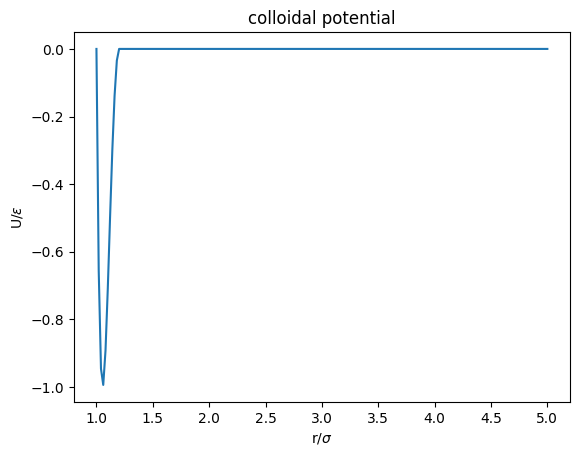

In [415]:
def phi_C(r:float)->float:
    alpha=114
    rc=1.2
    r2=1/r**2
    if r>=rc:
        return 0
    else:
        return alpha*(r2-1)*(rc**2*r2-1)**2
    
x=np.linspace(1,5,200)
fig, ax = plt.subplots()

ax.plot(x,[phi_C(i) for i in x])
ax.set_title("colloidal potential")
ax.set_xlabel("r/$\sigma$")
ax.set_ylabel("U/$\epsilon$")
plt.savefig("phi_C.png")

In [90]:
xi=[0,2,3]
xj=[2,5,6]
list(zip(xi,xj))
print(sum((xia-xja)**2 for xia, xja in zip(xi, xj)))

22


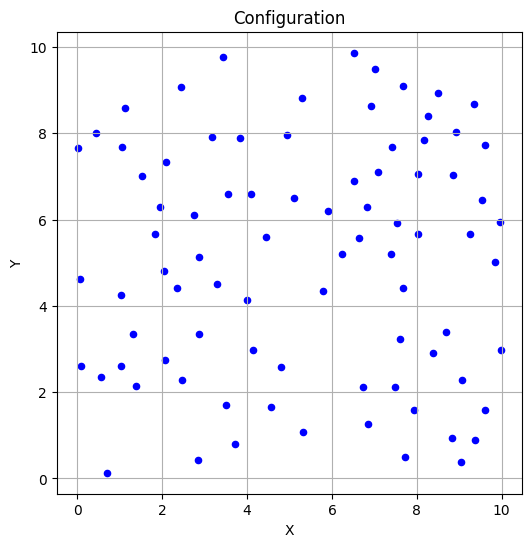

total atomic potential energy is: 15476.424688856272
total colloidal potential energy is: 181410.78440633728
total LJ potential energy is: 951283.1297016934


In [420]:
def init_mc(rho:float,L:float,type:int)->np.ndarray:
    if type not in (0, 1):
        raise ValueError("Invalid value for 'type' parameter. It must be 0 or 1. 0 for random positions, 1 for ordered lattice")
    
    N = int(rho * L**2)
    n = int(np.sqrt(N))  
    
    if type==1:
        coordinates = np.zeros((n**2, 2))
        s = L / n
        shift=(L-(n-1)*s)/2

        k = 0
        for i in range(n):
            for j in range(n):
                coordinates[k] = [i * s+shift, j * s+shift]
                k += 1
                
        return coordinates
    
    if type==0:
        coordinates=np.zeros((N,2))
        count = 0
        while count < N:
            x = np.random.uniform(0, L)
            y = np.random.uniform(0, L)
            if count == 0:
                coordinates[count] = [x, y]
                count += 1
            else:
                distances = np.linalg.norm(coordinates[:count] - np.array([x, y]), axis=1)
                if np.all(distances >= 0.5):
                    #print(distances)
                    coordinates[count] = [x, y]
                    count += 1
                    
        return coordinates
        
def init_md(rho:float,L:float,T0:float,type:int)->list[np.ndarray]:
    if type not in (0, 1):
        raise ValueError("Invalid value for 'type' parameter. It must be 0 or 1. 0 for random positions, 1 for ordered lattice")
    
    N = int(rho * L**2)
    n = int(np.sqrt(N))  
    
    if type==1:
        coordinates = np.zeros((n**2, 2))
        s = L / n
        shift=(L-(n-1)*s)/2

        k = 0
        for i in range(n):
            for j in range(n):
                coordinates[k] = [i * s+shift, j * s+shift]
                k += 1
        
        velocities=np.zeros((n**2,2))
        for i in range(n**1):
            velocities[i][0]=np.random.normal(0, np.sqrt(T0))
            velocities[i][1]=np.random.normal(0, np.sqrt(T0))
        
        return [coordinates,velocities]
    
    if type==0:
        coordinates=np.zeros((N,2))
        velocities=np.zeros((N,2))
        
        count = 0
        while count < N:
            x = np.random.uniform(0, L)
            y = np.random.uniform(0, L)
            if count == 0:
                coordinates[count] = [x, y]
                velocities[count][0]=np.random.normal(0, np.sqrt(T0))
                velocities[count][1]=np.random.normal(0, np.sqrt(T0))
                count += 1
            else:
                distances = np.linalg.norm(coordinates[:count] - np.array([x, y]), axis=1)
                if np.all(distances >= 0.5):
                    #print(distances)
                    coordinates[count] = [x, y]
                    velocities[count][0]=np.random.normal(0, np.sqrt(T0))
                    velocities[count][1]=np.random.normal(0, np.sqrt(T0))
                    count += 1
                    
        return [coordinates,velocities]

def plot_configuration(coordinates: np.ndarray):
    plt.figure(figsize=(6, 6))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], color='b', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Configuration')
    plt.grid(True)
    plt.show()
    
def plot_list_values(lst,listname,xlabel,ylabel):
    plt.plot(range(len(lst)), lst)
    plt.xlabel(str(xlabel))
    plt.ylabel(str(ylabel))
    plt.title(str(listname))

T1=0.728
rho1=0.8442
T2=1
rho2=0.1

box=10

[init_config,init_v]=init_md(rho1,box,0.001*T1,0)
plot_configuration(init_config)

#print(init_config)
print("total atomic potential energy is:",pairwise_potential(phi_A,init_config,box))
print("total colloidal potential energy is:",pairwise_potential(phi_C,init_config,box))
print("total LJ potential energy is:",pairwise_potential(lj_potential_cut,init_config,box))

In [152]:
import math
from decimal import Decimal


def my_remainder(a:float,b:float):
    dec_b=Decimal(str(b))
    remainder=Decimal(str(a))%Decimal(str(b))
    if remainder<0:
        return float(remainder+dec_b)
    return float(remainder)



0.3
4.43
0.3


7.39239832057368
1.3855520335687705
8.173728193805616
2.4662372855994183
7.575442330543322
1.6744039163710882
8.821515313345905
5.82674436056728
5.3639079717706455
7.491386404957141
2.2984054098277515
8.555489008887916
4.373013003941692
4.633219064350697
1.136068829723055
2.666612950151605
7.628975829786147
0.20099556003689667
2.053743896690051
4.481877258213538
6.5169929512315825
0.5443301407170453
2.786973730764921
5.798970091091213
7.191486817674908
1.6950078120650067
1.1050347249243497
1.713419274234186
4.895930059136302
7.978573827558044
5.50671310131389
3.4936620962931952
8.551226096445976
8.49661873327133
9.101325842914775
9.960957246895234
7.307465024405551
4.2579173988414505
4.6058357627289075
6.123352337438813
9.24561718135434
9.966316909434543
7.447656690598094
1.7006456357537154
9.17675345019354
9.036697819259512
5.243458772007454
1.8922027515202378
9.12824989438991
2.701748953558114
3.722519662456255
9.369596158038227
5.993586367677157
1.8597911829808997
8.340094443310612


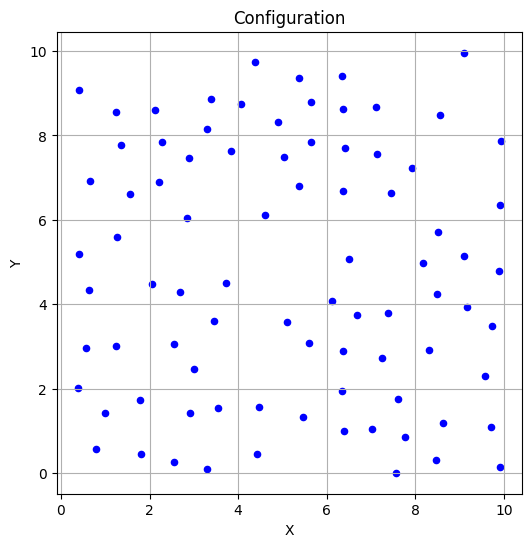

In [381]:
import random
from math import dist

def periodic_dist(a:np.ndarray,b:np.ndarray,box:float):
    dist=0
    for i in range(len(a)):
        if a[i]-b[i]<-box*0.5:
            dist+=(a[i]-b[i]+box)**2
        elif a[i]-b[i]>box*0.5:
            dist+= (a[i]-b[i]-box)**2
        else:
            dist+=(a[i]-b[i])**2

    return dist**0.5
        

def pairwise_potential_gradient(gradient: Callable[[float], float], box:float,xss:np.ndarray,gradient_components:np.ndarray) -> np.ndarray:
    """
    calculate the gradient of the total pairwise energy w.r.t. the particle coordinates.
    
    :param gradient: computes the magnitude of the gradient for a single pair
    :param xss: n x d array of particle coordinates
    :return: n x d array of the derivative of the total energy w.r.t. particle coordinates
    """
    
    n, d = xss.shape
    
    for i in range(n):
        for alpha in range(d):
            sum=0
            for j in range(n):
                if j!=i:
                    distance=periodic_dist(xss[i],xss[j],box)
                    if xss[i,alpha]-xss[j,alpha]<-box*0.5:
                        sum+=(xss[i,alpha]-xss[j,alpha]+box)/distance*gradient(distance)
                    elif xss[i,alpha]-xss[j,alpha]>box*0.5:
                        sum+=(xss[i,alpha]-xss[j,alpha]-box)/distance*gradient(distance)
                    else:
                        sum+=(xss[i,alpha]-xss[j,alpha])/distance*gradient(distance)
            gradient_components[i][alpha]=sum
            
    return gradient_components

def velocity_verlet(t_step:float,x:np.ndarray,v:np.ndarray,f_old:np.ndarray,f_new:np.ndarray,box:float,potential_gradient:Callable[[float],float]):
    f_old=-pairwise_potential_gradient(potential_gradient,box,x,f_old)
    
    n,d=x.shape
    
    for i in range(n):
        for j in range(d):
            x[i][j]=my_remainder(x[i][j]+v[i][j]*t_step+0.5*f_old[i][j]*t_step**2,box)
            
    f_new=-pairwise_potential_gradient(potential_gradient,box,x,f_new)
    v=v+(f_old+f_new)*0.5*t_step
    
def anderson(T:float,velocities:np.ndarray):
    N=velocities.shape[0]
    rand_index=np.random.randint(0, N)
    velocities[rand_index][0]=np.random.normal(0, np.sqrt(T))
    velocities[rand_index][1]=np.random.normal(0, np.sqrt(T))

def md_simulation(t_step:float,total_step:int,T:float,box:float,interval:float,coordinates:np.ndarray,velocities:np.ndarray):
    N=coordinates.shape[0]
    energies=list(range(total_step))
    f_old=np.zeros_like(velocities)
    f_new=np.zeros_like(velocities)
    
    step=0
    while step<total_step:
        flag=0

        count_before_collision=np.random.poisson(interval)
        for j in range(count_before_collision):
            energies[step]=pairwise_potential(phi_A,coordinates,box)
            velocity_verlet(t_step,coordinates,velocities,f_old,f_new,box,phi_A_derivative)
            step+=1
            if step==total_step:
                flag=1
                break
        if flag==1:
            break
            
        #anderson(T,velocities)

    plot_configuration(coordinates)
    return energies

def mc_simulation(total_step:int,T:float,box:float,sigma:float, coordinates: np.ndarray):
    # T is the temparature; sigma is the magnitude of random displacement
    N=coordinates.shape[0]
    energies=list(range(total_step))
    
    for i in range(total_step):
        e_old=pairwise_potential(phi_A,coordinates,box)
        rand_index=np.random.randint(0, N)
        displace_x=np.random.normal(0, sigma)
        displace_y=np.random.normal(0, sigma)
        coordinates[rand_index][0]=my_remainder((coordinates[rand_index][0]+displace_x),box)
        print(coordinates[rand_index][0])
        coordinates[rand_index][1]=my_remainder((coordinates[rand_index][1]+displace_y),box)
        print(coordinates[rand_index][1])
        e_new=pairwise_potential(phi_A,coordinates,box)
        
        random_number = random.random()   
        if random_number<np.exp(-(e_new-e_old)/T):
            
            energies[i]=e_new
        else:
            energies[i]=e_old
            coordinates[rand_index][0]=my_remainder((coordinates[rand_index][0]-displace_x),box)
            coordinates[rand_index][1]=my_remainder((coordinates[rand_index][1]-displace_y),box)
            
        
    plot_configuration(coordinates)
    return energies

energies=mc_simulation(100,T2,10,5,init_config)


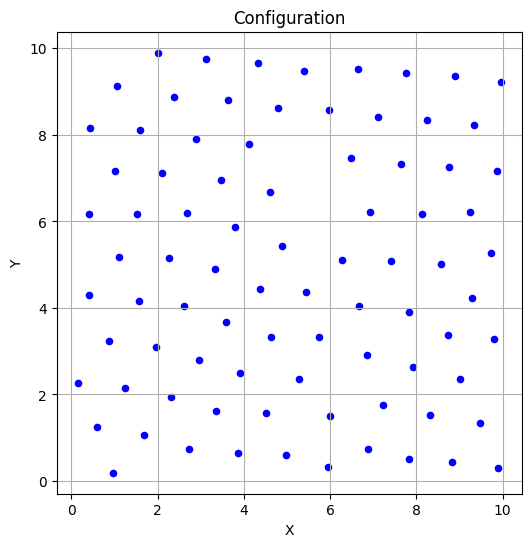

[-208.9119906411852, -208.9145991040716, -208.91721723826157, -208.91984503609473, -208.9224824898769, -208.9251296383367, -208.9277867911598, -208.9304538841617, -208.93313087898633, -208.9358177719806, -208.93851455902333, -208.94122123554106, -208.9439377965247, -208.94666423654425, -208.94940054976325, -208.95214672995155, -208.9549027705004, -208.9576686644328, -208.96044440441588, -208.96322994876942, -208.96602458869353, -208.96882794044126, -208.97164010173435, -208.9744610741183, -208.97729083806533, -208.98012926865556, -208.98297635211117, -208.98583208028072, -208.98869644499365, -208.99156943806037, -208.9944510683743, -208.99734151194673, -209.0002407501054, -209.00314876141795, -209.00606552488236, -209.00899101990862, -209.01192522630237, -209.01486812424957, -209.01781969429993, -209.02077991735192, -209.02374877463757, -209.02672624770835, -209.02971231835264, -209.03270685515443, -209.03570829828175, -209.03871663463661, -209.0417318518682, -209.04475393833076, -209.

In [423]:
energies_md=md_simulation(0.014, 10000,T1,box,3,init_config,init_v)
print(energies_md)

-38.55717902164322
-38.55717902164322
-0.4590140359719431
87.54373166753362
-0.24266507478773006


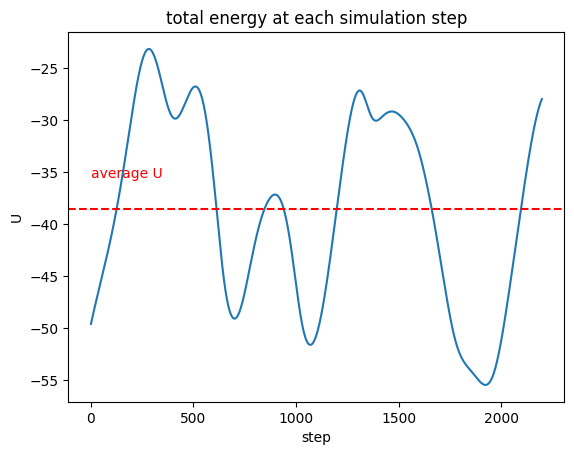

In [419]:
energies_md_trunc=energies_md[2800:]
plot_list_values(energies_md_trunc,"total energy at each simulation step","step","U")
length = len(energies_md_trunc)
ave_energy=sum(energies_md_trunc)/length
plt.axhline(y=ave_energy, color='red', linestyle='--')
plt.text(0, ave_energy+3, 'average U', color='red')
print(ave_energy)


ave_energy_trunc=sum(energies_md_trunc)/len(energies_md_trunc)
print(ave_energy_trunc)
print(ave_energy_trunc/init_config.shape[0])
squared_energies_trunc = list(map(lambda x: x**2, energies_md_trunc))
fluc_energy=sum(squared_energies_trunc)/len(energies_md_trunc)-ave_energy_trunc**2
print(fluc_energy)
print(fluc_energy**0.5/ave_energy_trunc)

-1.272
